# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2021/07/16<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Healing MNIST

In [ ]:
import numpy as np
import scipy.ndimage
import random
from tensorflow.keras.datasets import mnist


def apply_square(img, square_size):
    img = np.array(img)
    img[:square_size, :square_size] = 255
    return img


def apply_noise(img, bit_flip_ratio):
    img = np.array(img)
    mask = np.random.random(size=(28,28)) < bit_flip_ratio
    img[mask] = 255 - img[mask]
    return img


def get_rotations(img, rotation_steps):
    for rot in rotation_steps:
        img = scipy.ndimage.rotate(img, rot, reshape=False)
        yield img


def binarize(img):
    return (img > 127).astype(np.int)


def heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle):
    squares_begin = np.random.randint(0, seq_len - square_count)
    squares_end = squares_begin + square_count

    rotations = []
    rotation_steps = np.random.normal(size=seq_len, scale=max_angle)
    
    direction = random.randint(0, 1)
    if direction == 0:
      rotation_steps = abs(rotation_steps)
    else:
       rotation_steps = abs(rotation_steps)*-1
    rotation_steps = np.sort(rotation_steps)

    for idx, rotation in enumerate(get_rotations(img, rotation_steps)):
        # Don't add the squares right now
        # if idx >= squares_begin and idx < squares_end:
        #     rotation = apply_square(rotation, square_size)
        
        # Don't add noise for now
        # noisy_img = apply_noise(rotation, noise_ratio)
        noisy_img = rotation
        binarized_img = binarize(noisy_img)
        rotations.append(binarized_img)

    return rotations, rotation_steps, direction


class HealingMNIST():
    def __init__(self, seq_len=10, square_count=3, square_size=5, noise_ratio=0.15, digits=range(10), max_angle=10, max_number_per_class=10000):
        lables_counts = {}
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        mnist_train = [(img,label) for img, label in zip(x_train, y_train) if label in digits]
        mnist_test = [(img, label) for img, label in zip(x_test, y_test) if label in digits]

        train_images = []
        test_images = []
        train_rotations = []
        test_rotations = []
        train_labels = []
        test_labels = []

        for img, label in mnist_train:
            
            if label in lables_counts:
              lables_counts[label] += 1
            else:
              lables_counts[label] = 0
            if lables_counts[label] >= max_number_per_class:
                continue

            train_img, train_rot, direction = heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle)
            train_images.append(train_img)
            train_rotations.append(train_rot)
           
            train_labels.append(str(label) + "_" + str(direction))

        for img, label in mnist_test:
            test_img, test_rot, direction = heal_image(img, seq_len, square_count, square_size, noise_ratio, max_angle)
            test_images.append(test_img)
            test_rotations.append(test_rot)
            test_labels.append(str(label) + "_" + str(direction))
        _,train_labels = np.unique(train_labels, return_inverse=True)
        _,test_labels = np.unique(test_labels, return_inverse=True)
        self.train_images = np.array(train_images)
        self.test_images = np.array(test_images)
        self.train_rotations = np.array(train_rotations)
        self.test_rotations = np.array(test_rotations)
        self.train_labels = np.array(train_labels)
        self.test_labels = np.array(test_labels)

## Full Healing MNIST Data - 3000 per class (digit + rotation)

In [ ]:
data = HealingMNIST()
x_train, y_train = data.train_images.reshape(data.train_images.shape[0],data.train_images.shape[1], data.train_images.shape[2] * data.train_images.shape[3]), data.train_labels
x_test, y_test = data.test_images.reshape(data.test_images.shape[0],data.test_images.shape[1], data.test_images.shape[2] * data.test_images.shape[3]), data.test_labels
x_train.shape

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(60000, 10, 784)

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [ ]:
num_classes = len(np.unique(y_train))
num_classes

20

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

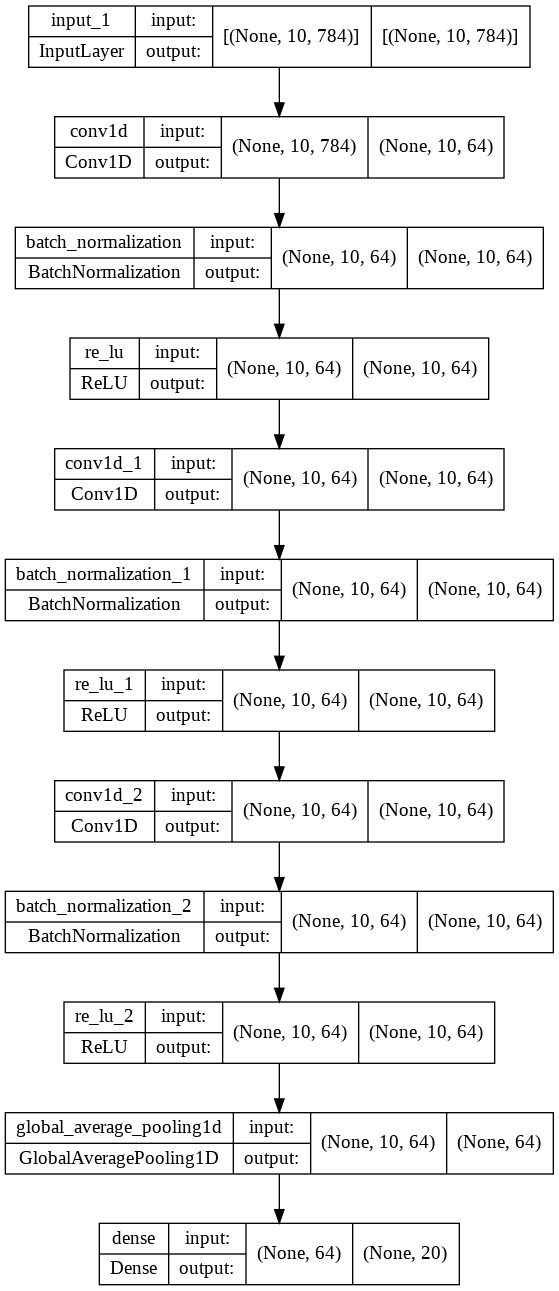

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "full_data_best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
1500/1500 [==============================] - 28s 18ms/step - loss: 0.4410 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.1980 - val_sparse_categorical_accuracy: 0.9407 - lr: 0.0010
Epoch 2/500
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.1597 - val_sparse_categorical_accuracy: 0.9490 - lr: 0.0010
Epoch 3/500
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9561 - val_loss: 0.1423 - val_sparse_categorical_accuracy: 0.9568 - lr: 0.0010
Epoch 4/500
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1215 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.1275 - val_sparse_categorical_accuracy: 0.9607 - lr: 0.0010
Epoch 5/500
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9622 - lr: 0.0010
Epoch 6/50

## Evaluate model on test data

In [ ]:
model = keras.models.load_model("full_data_best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 3s 7ms/step - loss: 0.1107 - sparse_categorical_accuracy: 0.9664
Test accuracy 0.9664000272750854
Test loss 0.11066468805074692


## Plot the model's training and validation loss

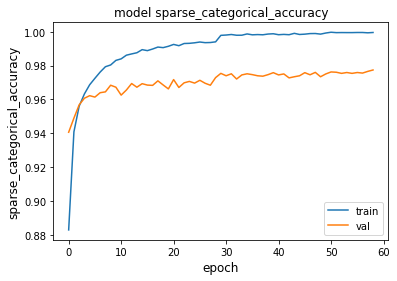

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Limited Healing MNIST Data - 500 per class (digit + rotation)

In [ ]:
data = HealingMNIST(max_number_per_class=500)
x_train, y_train = data.train_images.reshape(data.train_images.shape[0],data.train_images.shape[1], data.train_images.shape[2] * data.train_images.shape[3]), data.train_labels
x_test, y_test = data.test_images.reshape(data.test_images.shape[0],data.test_images.shape[1], data.test_images.shape[2] * data.test_images.shape[3]), data.test_labels
x_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(5000, 10, 784)

## Train Model

In [ ]:
pochs = 500
batch_size = 32

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "limited_data_best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
125/125 [==============================] - 3s 19ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.9590 - val_sparse_categorical_accuracy: 0.7960 - lr: 0.0010
Epoch 2/500
125/125 [==============================] - 2s 17ms/step - loss: 0.5358 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.5632 - val_sparse_categorical_accuracy: 0.8710 - lr: 0.0010
Epoch 3/500
125/125 [==============================] - 2s 19ms/step - loss: 0.3450 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.5133 - val_sparse_categorical_accuracy: 0.8610 - lr: 0.0010
Epoch 4/500
125/125 [==============================] - 2s 18ms/step - loss: 0.2405 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.4394 - val_sparse_categorical_accuracy: 0.8710 - lr: 0.0010
Epoch 5/500
125/125 [==============================] - 2s 18ms/step - loss: 0.1801 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.3972 - val_sparse_categorical_accuracy: 0.8880 - lr: 0.0010
Epoch 6/500
125/125 [====

## Model Evaluation 

In [ ]:
model = keras.models.load_model("limited_data_best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 2s 7ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9300
Test accuracy 0.9300000071525574
Test loss 0.29822659492492676


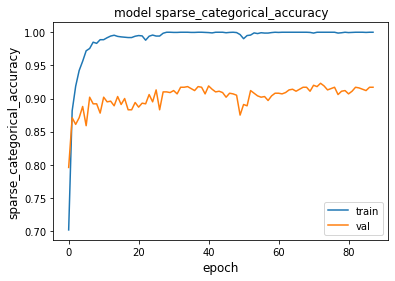

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Tiny Healing MNIST Data - 50 per class (digit + rotation)

In [ ]:
data = HealingMNIST(max_number_per_class=50)
x_train, y_train = data.train_images.reshape(data.train_images.shape[0],data.train_images.shape[1], data.train_images.shape[2] * data.train_images.shape[3]), data.train_labels
x_test, y_test = data.test_images.reshape(data.test_images.shape[0],data.test_images.shape[1], data.test_images.shape[2] * data.test_images.shape[3]), data.test_labels
x_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(500, 10, 784)

# Train Model

In [ ]:
pochs = 500
batch_size = 32

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "tiny_data_best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
13/13 [==============================] - 2s 47ms/step - loss: 2.4551 - sparse_categorical_accuracy: 0.3300 - val_loss: 2.7151 - val_sparse_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/500
13/13 [==============================] - 0s 24ms/step - loss: 1.4882 - sparse_categorical_accuracy: 0.7300 - val_loss: 2.4783 - val_sparse_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 3/500
13/13 [==============================] - 0s 23ms/step - loss: 1.0931 - sparse_categorical_accuracy: 0.8200 - val_loss: 2.2995 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 4/500
13/13 [==============================] - 0s 23ms/step - loss: 0.8060 - sparse_categorical_accuracy: 0.8975 - val_loss: 2.1308 - val_sparse_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 5/500
13/13 [==============================] - 0s 28ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.9375 - val_loss: 1.9816 - val_sparse_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 6/500
13/13 [================

## Model Evaluation

In [ ]:
model = keras.models.load_model("tiny_data_best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 3s 7ms/step - loss: 0.8514 - sparse_categorical_accuracy: 0.7553
Test accuracy 0.755299985408783
Test loss 0.8513950109481812


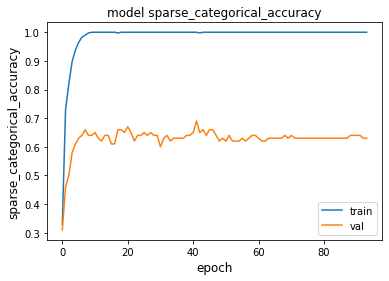

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()